In [2]:
import numpy as np
import  matplotlib.pyplot as plt

In [94]:
# let's generate some data for fitting 
dx = 0.05                       # spacing between measurements 
N = int(1.5/dx) +1              # no of data points 
x = np.linspace(-0.75,0.75,N)   # x axis data 

Text(0, 0.5, '$B_z$')

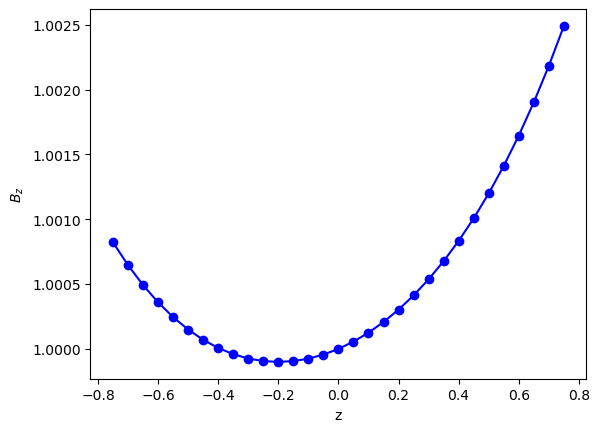

In [95]:
# generate 1D magentic field data (fake data)
cf = [1,0.001,0.0025,0.0002, 0.00079]
Bz = cf[0]  + cf[1]*x + cf[2]*x**2 + cf[3]*x**3 + cf[4]*x**4
plt.plot(x,Bz,'bo-')
plt.xlabel('z')
plt.ylabel(r'$B_z$')

In [42]:
# using sypy curve fit 

from scipy.optimize import curve_fit

# fitting a second order curve 
def func_1(x,a,b,c):
    return a*x**2 + b*x + c

# fitting a 3rd order curve 
def func_2(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

# fitting 4th order curve 
def func_3(x,a,b,c,d,g):
    return a*x**4 + b*x**3 + c*x**2 + d*x + g


In [46]:
# coefficients using second order curve 
popt_1,pcov_1 = curve_fit(func_1,x,Bz,p0=(0.1,0.1,1))
order = 2
[print(f'Actual value = {cf[order-i]:4f} | predicted value = {popt_1[i]:4f} for {order-i} order coefficient ') for i in range(order+1)]

Actual value = 0.002500 | predicted value = 0.002905 for 2 order coefficient 
Actual value = 0.001000 | predicted value = 0.001072 for 1 order coefficient 
Actual value = 1.000000 | predicted value = 0.999976 for 0 order coefficient 


[None, None, None]

Text(0, 0.5, '$B_z$')

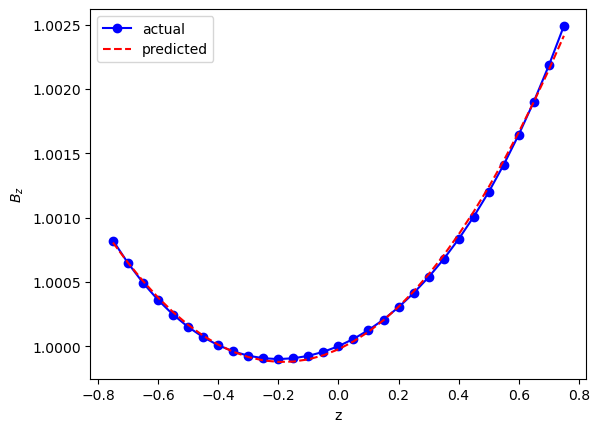

In [59]:
# plot actual vs predicted 
plt.plot(x,Bz,'bo-',label='actual')
plt.plot(x,func_1(x,*popt_1),'r--',label='predicted')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$B_z$')

In [47]:
# coefficients using third order curve 
popt_2,pcov_2 = curve_fit(func_2,x,Bz,p0=(0.1,0.1,0.1,1))
order = 3
[print(f'Actual value = {cf[order-i]:4f} | predicted value = {popt_2[i]:4f} for {order-i} order coefficient ') for i in range(order+1)]

Actual value = 0.000200 | predicted value = 0.000200 for 3 order coefficient 
Actual value = 0.002500 | predicted value = 0.002905 for 2 order coefficient 
Actual value = 0.001000 | predicted value = 0.001000 for 1 order coefficient 
Actual value = 1.000000 | predicted value = 0.999976 for 0 order coefficient 


[None, None, None, None]

In [51]:
# coefficients of 4th order curve 
popt_3,pcov_3 = curve_fit(func_3,x,Bz,p0=(0.1,0.1,0.1,0.01,1))
order = 4
[print(f'Actual value = {cf[order-i]:4f} | predicted value = {popt_3[i]:4f} for {order-i} order coefficient ') for i in range(order+1)]

Actual value = 0.000790 | predicted value = 0.000790 for 4 order coefficient 
Actual value = 0.000200 | predicted value = 0.000200 for 3 order coefficient 
Actual value = 0.002500 | predicted value = 0.002500 for 2 order coefficient 
Actual value = 0.001000 | predicted value = 0.001000 for 1 order coefficient 
Actual value = 1.000000 | predicted value = 1.000000 for 0 order coefficient 


[None, None, None, None, None]

Text(0, 0.5, '$B_z$')

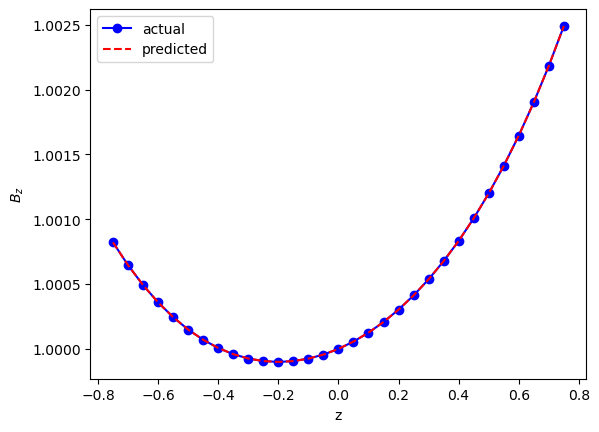

In [60]:
# plot actual vs predicted 
plt.plot(x,Bz,'bo-',label='actual')
plt.plot(x,func_3(x,*popt_3),'r--',label='predicted')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$B_z$')

Text(0, 0.5, 'RMSE_error')

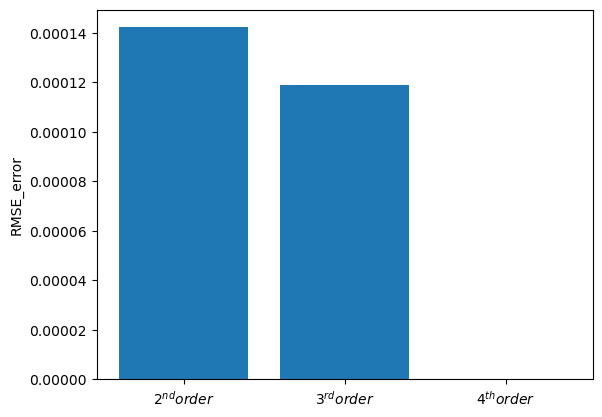

In [77]:
# how good is fitting ? 

Bz_pred_1 = func_1(x,*popt_1) 
Bz_pred_2 = func_2(x,*popt_2)
Bz_pred_3 = func_3(x,*popt_3)

def RMSE(actual,predicted):
    return np.sqrt(np.sum((actual-predicted)**2))

err_1 = RMSE(Bz,Bz_pred_1)
err_2 = RMSE(Bz,Bz_pred_2)
err_3 = RMSE(Bz,Bz_pred_3)

plt.bar([r'$2^{nd} order$',r'$3^{rd} order$',r'$4^{th} order$'],[err_1,err_2,err_3])
plt.ylabel('RMSE_error')

In [122]:
# using simple feed forward network 

import torch
import torch.nn as nn
from torch.optim import SGD

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.W1 = nn.Linear(1,12)
        self.W2 = nn.Linear(12,1)
        self.R = nn.ReLU()
        
    def forward(self,x):
        x = self.R(self.W1(x))
        x = self.W2(x)
        return x

In [127]:
def train_model(x,y,f,n_epochs=50):
    opt = SGD(f.parameters(),lr=0.001)
    L = nn.MSELoss()
    
    # train model 
    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()
        loss_value = L(f(x),y)
        loss_value.backward()
        opt.step()
        losses.append(loss_value.item())
    return f, losses

In [128]:
x = torch.linspace(-0.75,0.75,N).unsqueeze(dim=1)
Bz = cf[0]  + cf[1]*x + cf[2]*x**2 + cf[3]*x**3 + cf[4]*x**4

In [129]:
f = LinearRegressionModel()
f,loss = train_model(x,Bz,f)

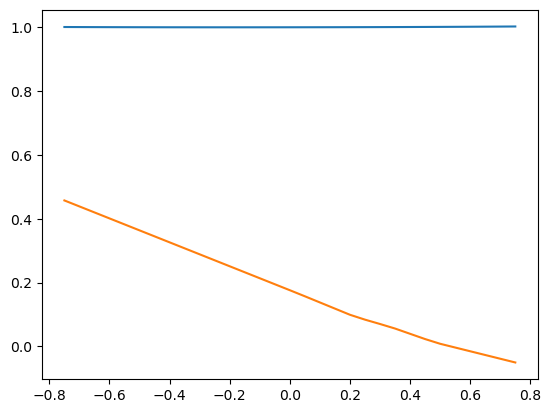

In [130]:
Bz_actual = Bz.detach().numpy()
Bz_predicted = f(x).detach().numpy()
x_axis = x.detach().numpy()


plt.plot(x_axis,Bz_actual)
plt.plot(x_axis,Bz_predicted)
